#TUIA - Aprendizaje Automático 1

##Trabajo práctico N°1: Regresión lineal

Integrantes:
- Suarez, Esteban
- Moresco, Brisa
- Brizuela Cipolletti, Sofía

#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerias

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from geopy.distance import geodesic

In [2]:
# https://drive.google.com/file/d/1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U/view?usp=drive_link
!gdown 1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U

Downloading...
From: https://drive.google.com/uc?id=1CQqGndC0Z4G9QNsNbzON2zYT8P9War_U
To: /content/uber_fares.csv
100% 23.5M/23.5M [00:00<00:00, 60.8MB/s]


# Informacion del dataset

In [3]:
# Carga del dataset
df = pd.read_csv("/content/uber_fares.csv")

In [4]:
# Visualización del dataset
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [7]:
# Cuento los valores faltantes en cada columna.
missing_values = df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

Valores faltantes por columna:
 key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [8]:
# Como se ve que hay valores nulos en dropoff_longitude y dropoff_latitude solamente, voy a validar si son sobre el mismo registro
# True -> Un unico registro

missing_rows = df[df[['dropoff_longitude', 'dropoff_latitude']].isnull().any(axis=1)]
print(len(missing_rows) == 1)

True


In [9]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [10]:
# Eliminamos las variables 'key' y 'date' ya que son columnas que no aportan información relevante para la predicción
df = df.drop(columns=['key', 'date'])

### Variable target 'fare_amount'

In [11]:
# Eliminamos las filas que tengan un valor negativo en la variable target (fare_amount)
df = df[df['fare_amount'] > 0]

In [12]:
df.fare_amount.describe()

,fare_amount
count,199978.000000
mean,11.362649
std,9.897079
min,0.010000
25%,6.000000
50%,8.500000
75%,12.500000
max,499.000000


# Graficos

- A continuacion se visualizan distribuciones de tarifas, días de la semana, horas, y se analiza la cantidad de viajes por hora y día a través de gráficos como boxplots, histogramas y heatmaps. Ademas,  Se clasifican las franjas horarias del día, se limpian valores atípicos en la cantidad de pasajeros, y se agrupan los tipos de viaje (Uber, UberEats, UberXL).

- Luego, se calcula la distancia entre el origen y el destino de los viajes utilizando coordenadas geográficas.
Por ultimo, visualizamos las coordenadas de origen y destino en mapas de calor para identificar áreas de alta densidad de viajes.

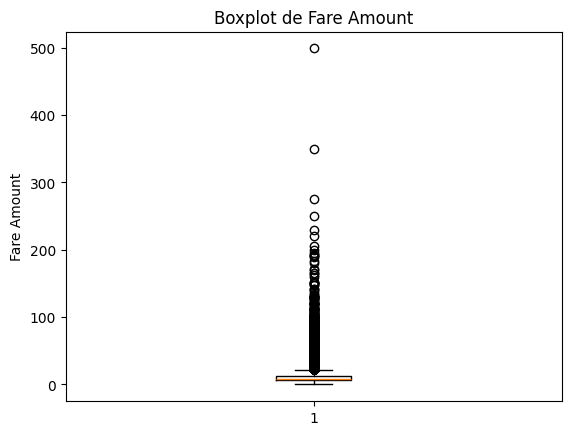

In [13]:
# Boxplot de la variable target
plt.boxplot(df['fare_amount'])
plt.title('Boxplot de Fare Amount')
plt.ylabel('Fare Amount')
plt.show()

### Análisis temporal

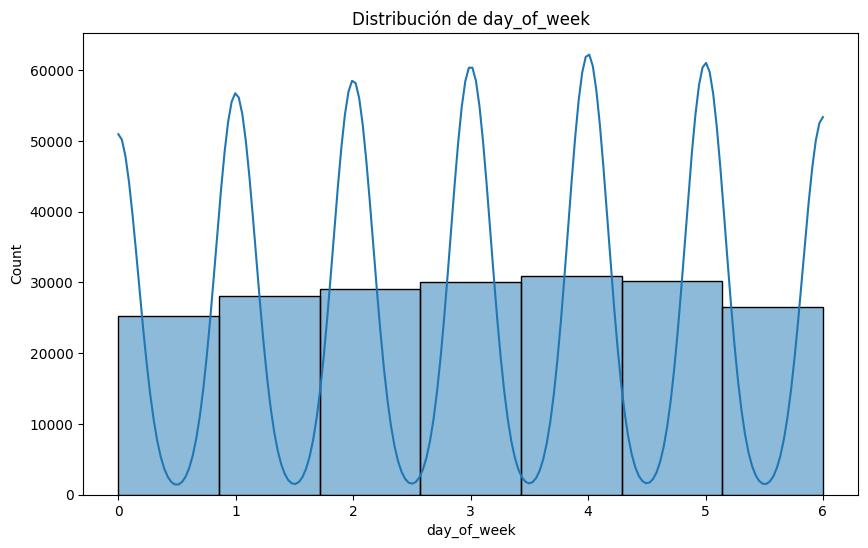

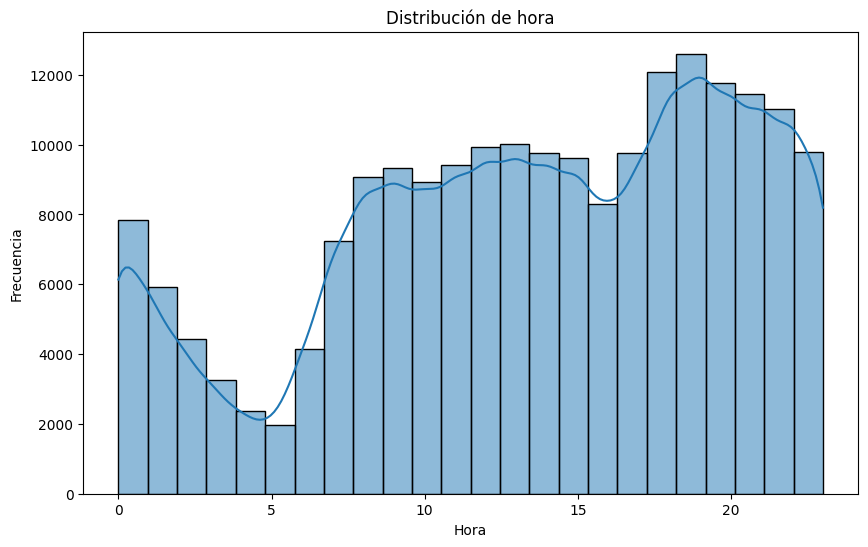

In [38]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

# Histograma del día de la semana
plt.figure(figsize=(10, 6))
sns.histplot(df['day_of_week'], bins=7, kde=True)
plt.title('Distribución de day_of_week')
plt.show()

# Histograma de la hora
plt.figure(figsize=(10, 6))
sns.histplot(df['hour'], bins=24, kde=True)
plt.title('Distribución de hora')
plt.xlabel('Hora')
plt.ylabel('Frecuencia')
plt.show()


### Heatmap de hora y día de la semana para visualizar a qué hora del día se realizan una mayor cantidad de viajes


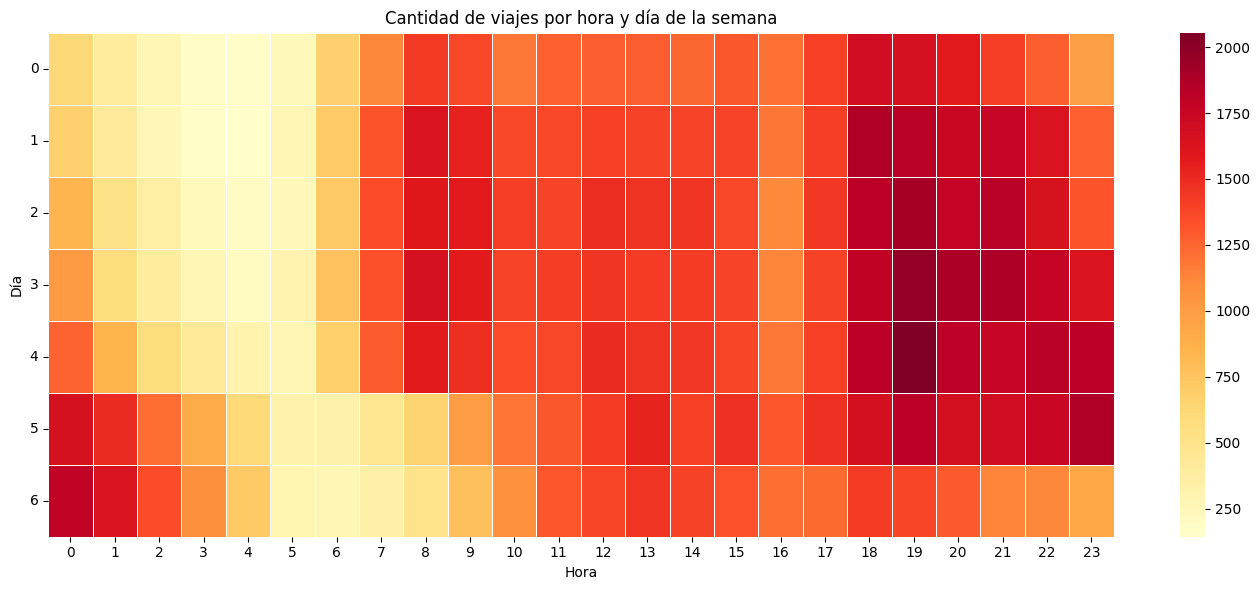

In [39]:
viajes_hora_dia = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(viajes_hora_dia, cmap='YlOrRd', linewidths=.5)
plt.title('Cantidad de viajes por hora y día de la semana')
plt.xlabel('Hora')
plt.ylabel('Día')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Promedio de tarifas por día y hora

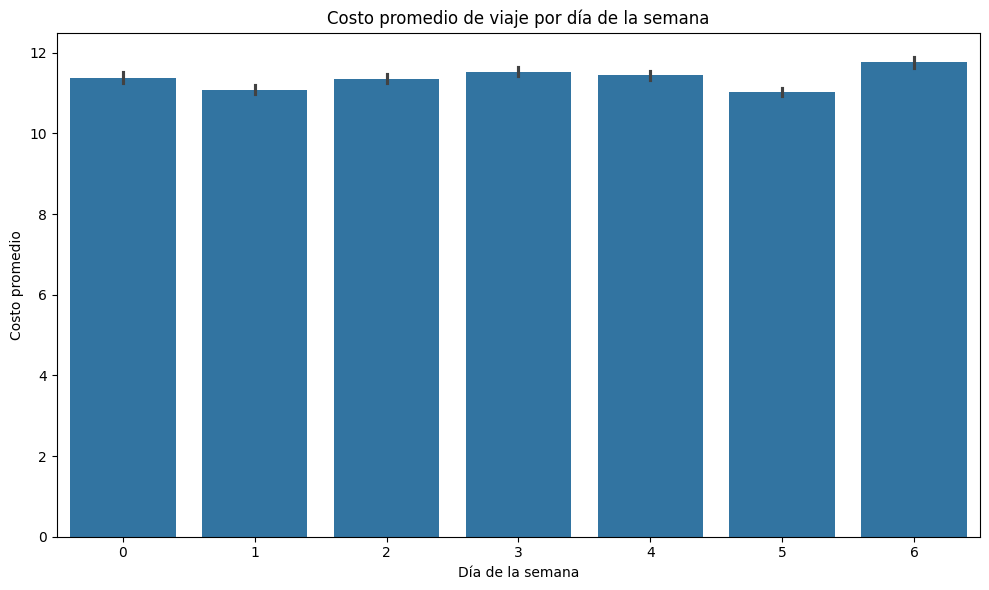

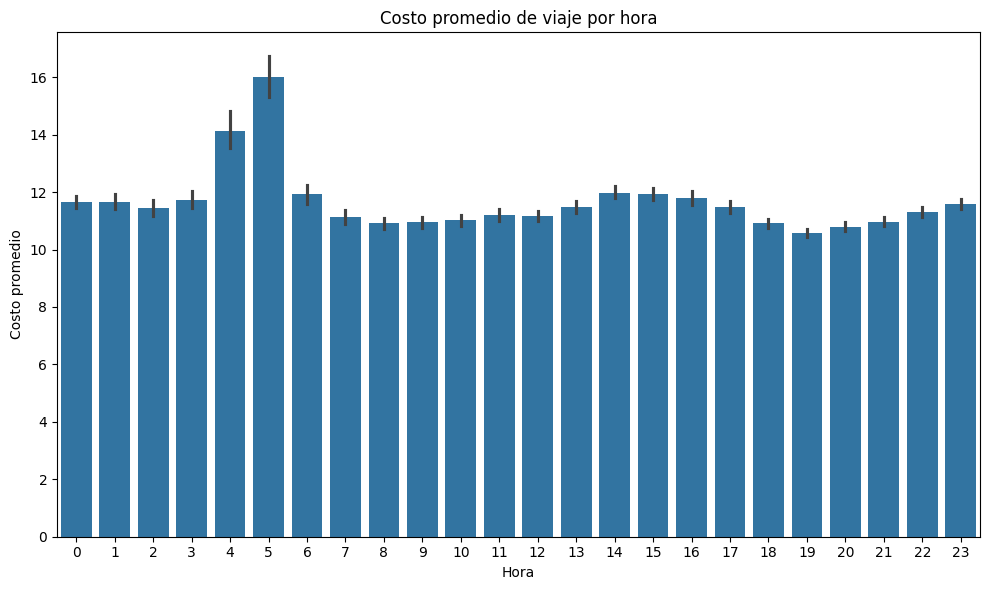

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='fare_amount', data=df)
plt.title('Costo promedio de viaje por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Costo promedio')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='fare_amount', data=df)
plt.title('Costo promedio de viaje por hora')
plt.xlabel('Hora')
plt.ylabel('Costo promedio')
plt.tight_layout()
plt.show()


### Clasificación por franja horaria (day_time)

In [41]:
df['day_time'] = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['madrugada', 'mañana', 'tarde', 'noche'],
    right=False
)

df = pd.get_dummies(df, columns=['day_time'])
print(df.filter(like='day_time_').head())


   day_time_madrugada  day_time_mañana  day_time_tarde  day_time_noche  \
0               False            False           False            True   
1               False            False           False            True   
2               False            False           False            True   
3               False             True           False           False   
4               False            False            True           False   

   day_time_madrugada  day_time_mañana  day_time_tarde  day_time_noche  
0               False            False           False            True  
1               False            False           False            True  
2               False            False           False            True  
3               False             True           False           False  
4               False            False            True           False  


### Cantidad de pasajeros

count    199978.000000
mean          1.683445
std           1.306932
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64


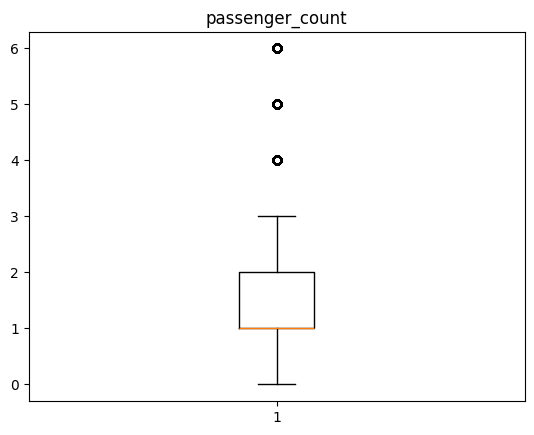

In [42]:
print(df.passenger_count.describe())  # Observación de outliers

# Reemplazo de valores outliers
df.loc[df['passenger_count'] > 6, 'passenger_count'] = df['passenger_count'].median()

# Boxplot
plt.boxplot(df['passenger_count'])
plt.title('passenger_count')
plt.show()


Se observa que hay un valor de 208 como máximo, lo cual es un outlier y debería ser reemplazado por la media, mediana

### Clasificación del tipo de viaje (uber_type)

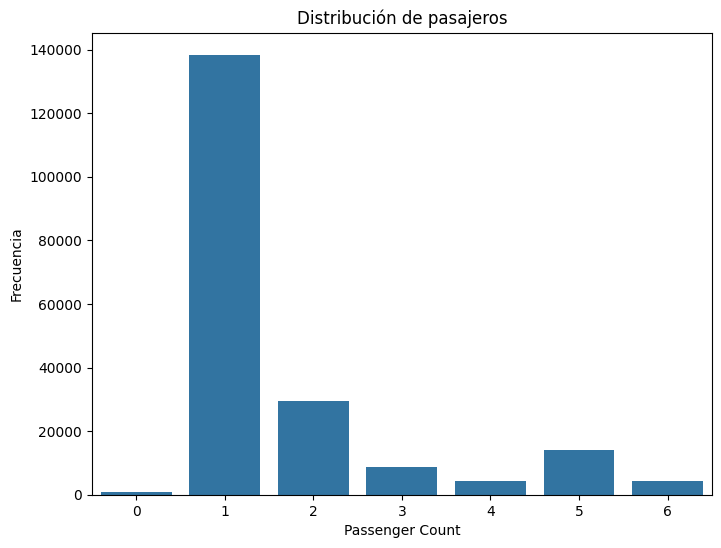

In [43]:
df['uber_type'] = df['passenger_count'].apply(lambda x: 'UberEats' if x == 0 else ('Uber' if x <= 4 else 'UberXL'))
df = pd.get_dummies(df, columns=['uber_type'])

# Conteo por número de pasajeros
plt.figure(figsize=(8, 6))
sns.countplot(x='passenger_count', data=df)
plt.title('Distribución de pasajeros')
plt.xlabel('Passenger Count')
plt.ylabel('Frecuencia')
plt.show()


## Coordenadas y distancia del viaje

Función para calcular la distancia a partir de las latitudes y longitudes del origen y del destino

In [44]:
def calcular_distancia(row):
    return geodesic((row['pickup_latitude'], row['pickup_longitude']),
                    (row['dropoff_latitude'], row['dropoff_longitude'])).km


####  Limpieza de coordenadas

In [45]:
df['dropoff_longitude'].fillna(df['dropoff_longitude'].median(), inplace=True)
df['dropoff_latitude'].fillna(df['dropoff_latitude'].median(), inplace=True)

lon_min, lon_max = -74.3, -73.6
lat_min, lat_max = 40.5, 41.0

df['pickup_longitude'] = np.clip(df['pickup_longitude'], lon_min, lon_max)
df['pickup_latitude'] = np.clip(df['pickup_latitude'], lat_min, lat_max)
df['dropoff_longitude'] = np.clip(df['dropoff_longitude'], lon_min, lon_max)
df['dropoff_latitude'] = np.clip(df['dropoff_latitude'], lat_min, lat_max)

df['trip_distance_km'] = df.apply(calcular_distancia, axis=1)


<ipython-input-45-48f4dcc69c79>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dropoff_longitude'].fillna(df['dropoff_longitude'].median(), inplace=True)
<ipython-input-45-48f4dcc69c79>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v

### Histogramas de coordenadas

 - Se visualizan las coordenadas de origen y destino en mapas de calor para identificar áreas de alta densidad de viajes.



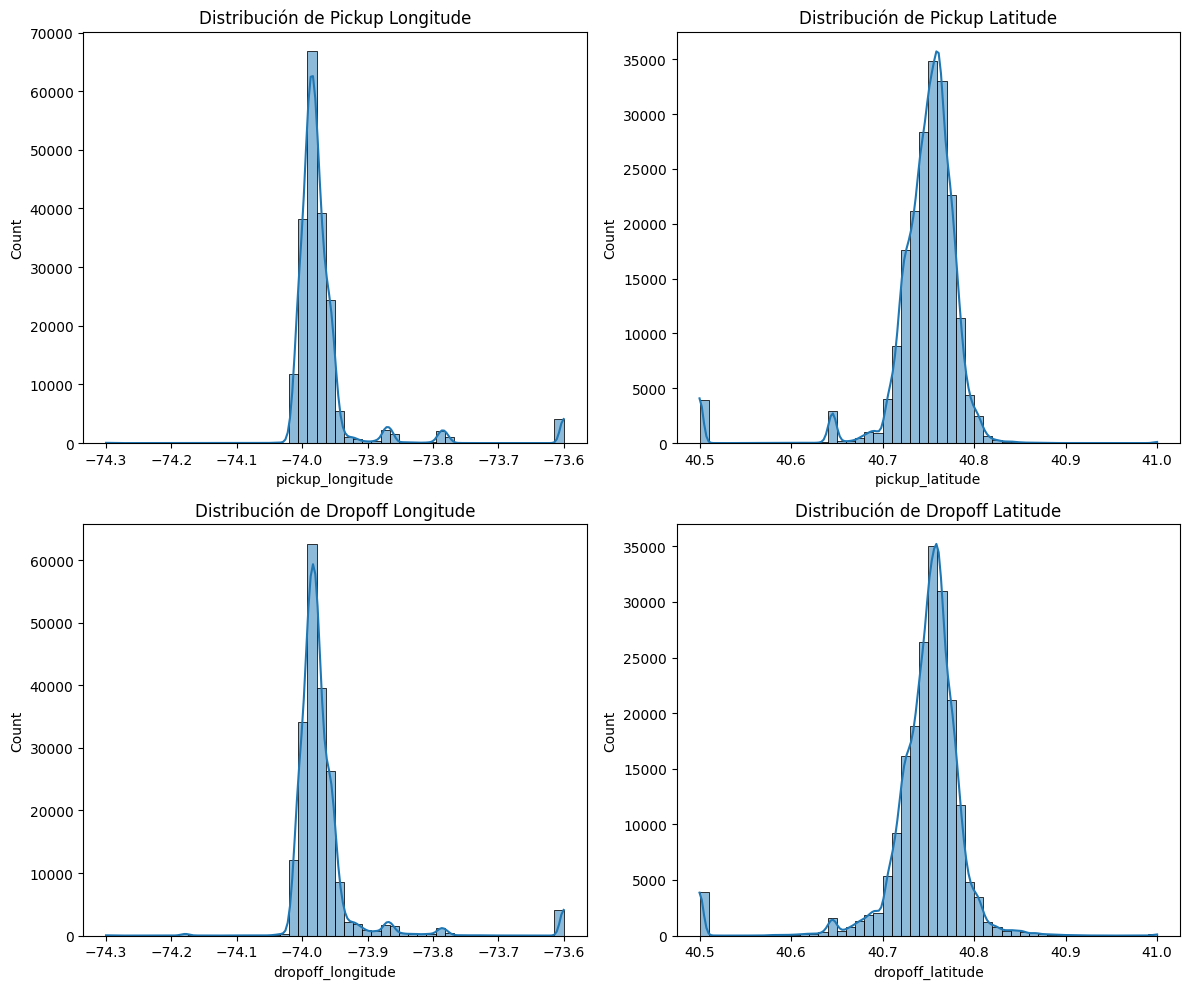

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['pickup_longitude'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Pickup Longitude')
sns.histplot(df['pickup_latitude'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Pickup Latitude')
sns.histplot(df['dropoff_longitude'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Dropoff Longitude')
sns.histplot(df['dropoff_latitude'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribución de Dropoff Latitude')
plt.tight_layout()
plt.show()


Se puede ver que en la latitud y longitud de origen y destino hay rangos donde se aglomeran los datos, esto nos hace suponer que hay sectores de NY donde se aglomeran los viajes.
Usamos mapas de calor para validar este supuesto.

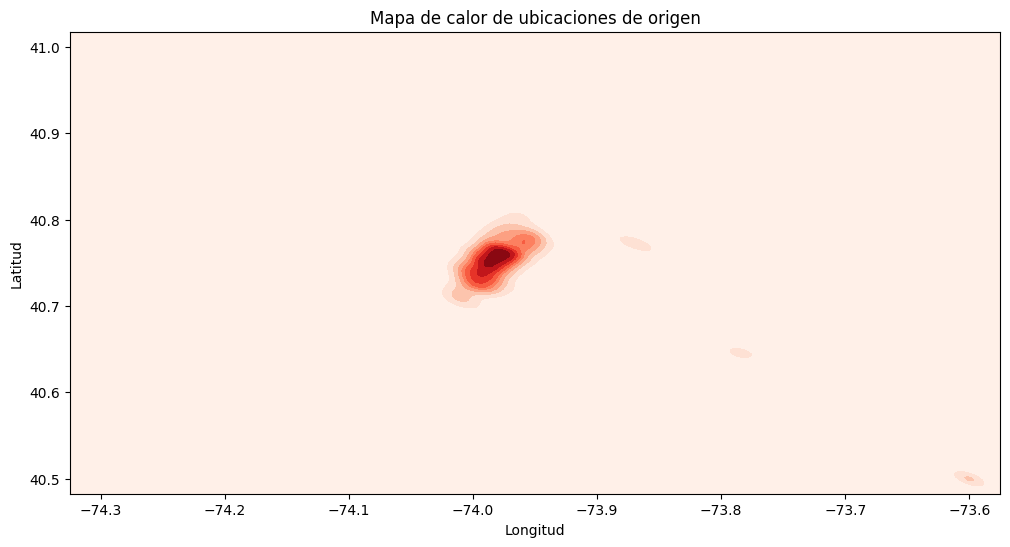

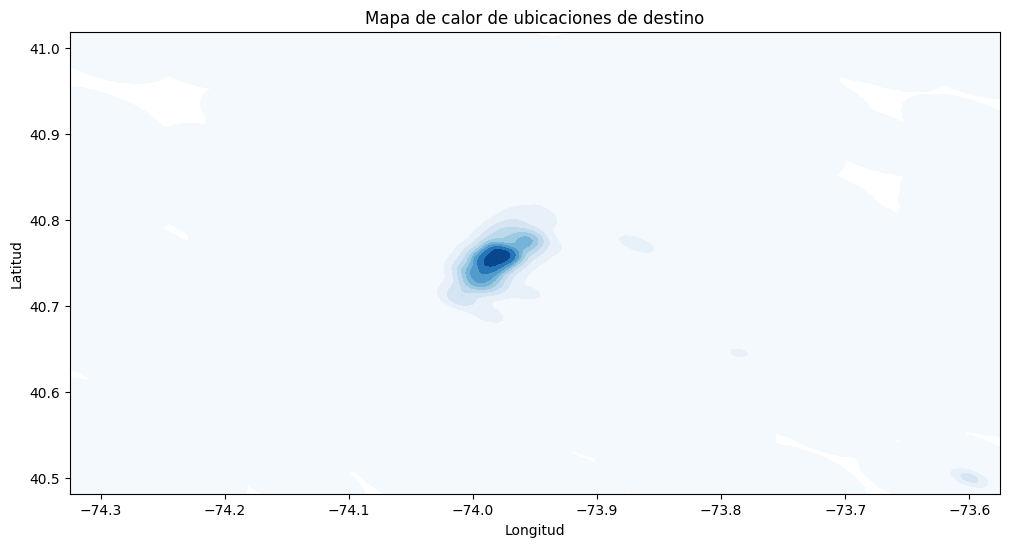

In [47]:
plt.figure(figsize=(12, 6))
sns.kdeplot(x=df['pickup_longitude'], y=df['pickup_latitude'], cmap='Reds', fill=True, thresh=0)
plt.title('Mapa de calor de ubicaciones de origen')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(x=df['dropoff_longitude'], y=df['dropoff_latitude'], cmap='Blues', fill=True, thresh=0)
plt.title('Mapa de calor de ubicaciones de destino')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


### Distancia del viaje


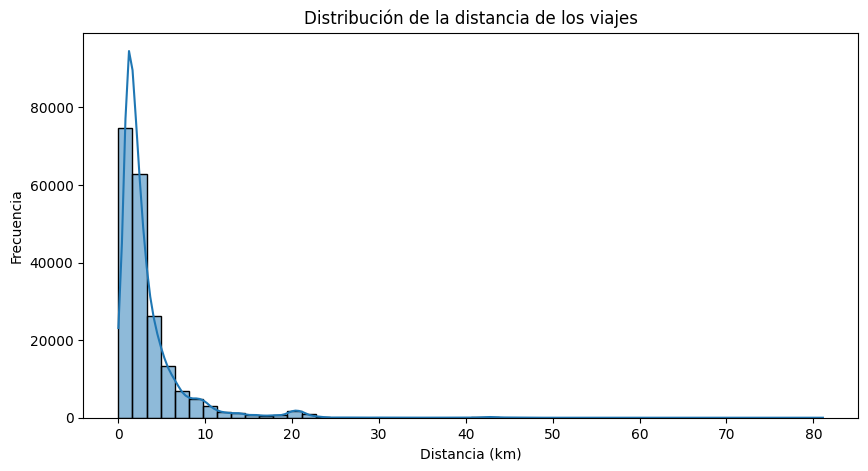

In [48]:
plt.figure(figsize=(10, 5))
sns.histplot(df['trip_distance_km'], bins=50, kde=True)
plt.title("Distribución de la distancia de los viajes")
plt.xlabel("Distancia (km)")
plt.ylabel("Frecuencia")
plt.show()


Se puede ver que la mayoria de los viajes son "viajes cortos"

# Matriz de correlación

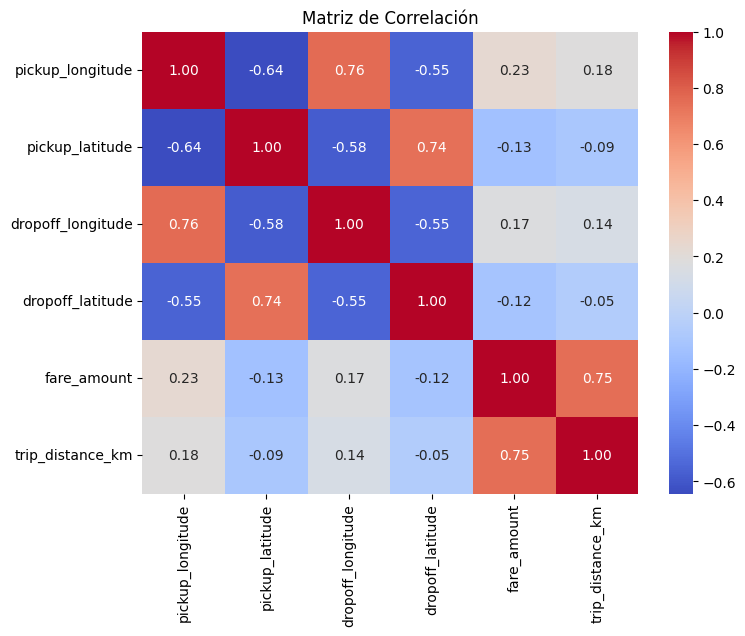

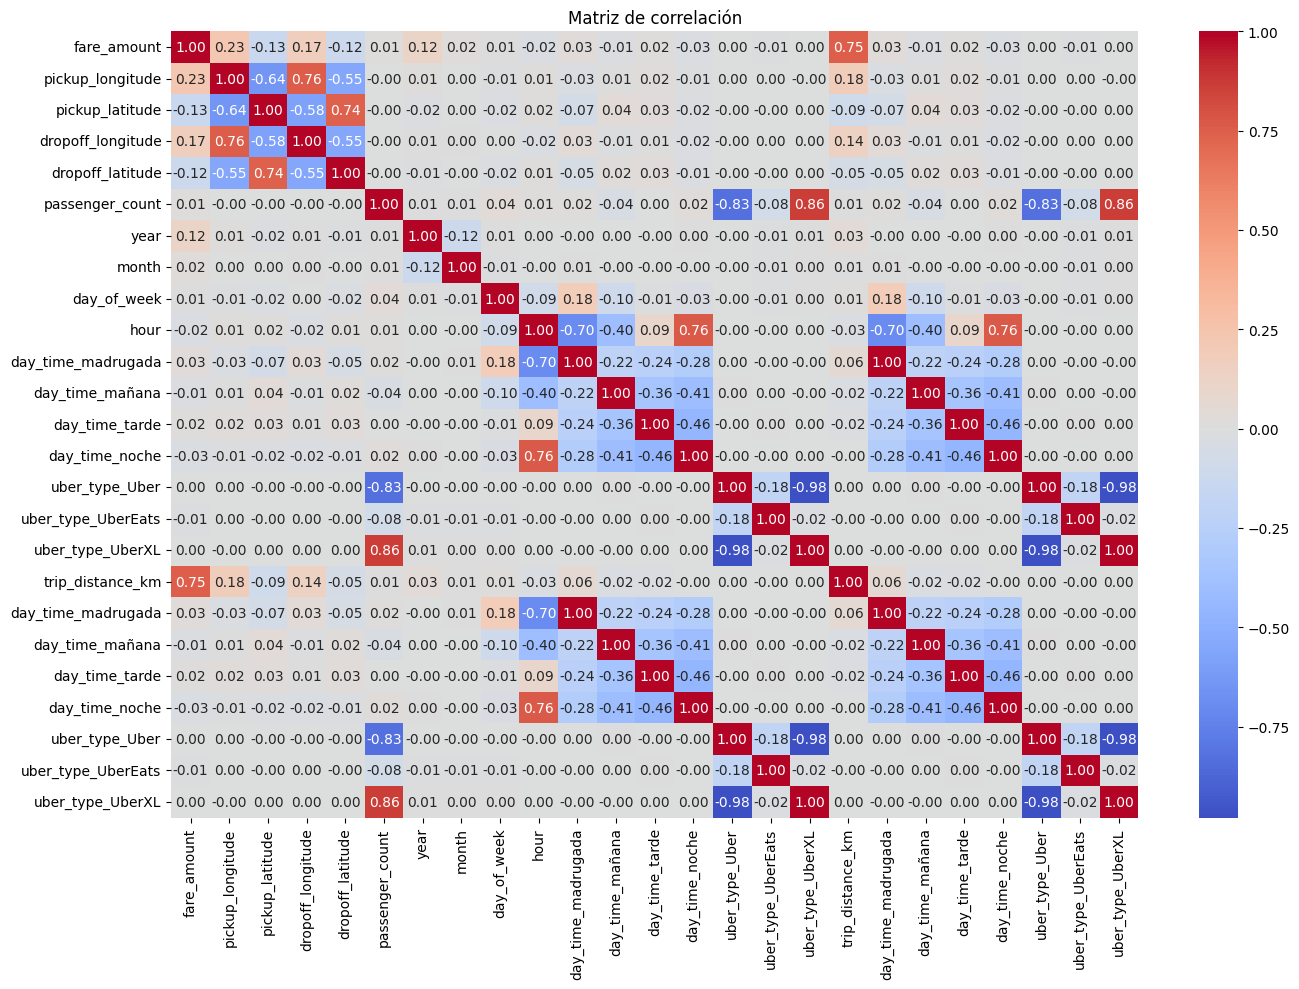

fare_amount           1.000000
trip_distance_km      0.746529
pickup_longitude      0.230292
dropoff_longitude     0.170873
year                  0.118535
day_time_madrugada    0.032285
day_time_madrugada    0.032285
month                 0.023565
day_time_tarde        0.017434
day_time_tarde        0.017434
passenger_count       0.011017
day_of_week           0.007407
uber_type_UberXL      0.002307
uber_type_UberXL      0.002307
uber_type_Uber        0.000058
uber_type_Uber        0.000058
uber_type_UberEats   -0.011468
uber_type_UberEats   -0.011468
day_time_mañana      -0.014168
day_time_mañana      -0.014168
hour                 -0.021467
day_time_noche       -0.026624
day_time_noche       -0.026624
dropoff_latitude     -0.115226
pickup_latitude      -0.130345
Name: fare_amount, dtype: float64


In [49]:
# Matriz de correlación selectiva
plt.figure(figsize=(8, 6))
sns.heatmap(df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'trip_distance_km']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Matriz de correlación completa
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

fare_corr = corr_matrix['fare_amount'].sort_values(ascending=False)
print(fare_corr)


# División del dataset y estandarización

In [50]:
features = [
    'trip_distance_km',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'year', 'passenger_count',
    'month', 'day_of_week', 'hour',
    'day_time_madrugada', 'day_time_mañana', 'day_time_tarde', 'day_time_noche',
    'uber_type_Uber', 'uber_type_UberXL', 'uber_type_UberEats'
]

X_train, X_test, y_train, y_test = train_test_split(df[features], df['fare_amount'], test_size=0.2, random_state=42)

X_train.describe()

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [51]:
X_train.describe()

,trip_distance_km,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,passenger_count,month,day_of_week,hour
count,159982.000000,159982.000000,159982.000000,159982.000000,159982.000000,159982.000000,159982.000000,159982.000000,159982.000000,159982.000000
mean,3.346880,-73.967962,40.745943,-73.967040,40.746254,2011.741096,1.682414,6.282182,3.047287,13.484661
std,4.040508,0.063262,0.044430,0.062966,0.046817,1.855980,1.305992,3.438106,1.946412,6.517412
min,0.000000,-74.300000,40.500000,-74.300000,40.500000,2009.000000,0.000000,1.000000,0.000000,0.000000
25%,1.215182,-73.992081,40.734765,-73.991428,40.733739,2010.000000,1.000000,3.000000,1.000000,9.000000
50%,2.122114,-73.981832,40.752566,-73.980118,40.753011,2012.000000,1.000000,6.000000,3.000000,14.000000
75%,3.874380,-73.967207,40.767182,-73.963623,40.768034,2013.000000,2.000000,9.000000,5.000000,19.000000
max,81.102752,-73.600000,41.000000,-73.600000,41.000000,2015.000000,6.000000,12.000000,6.000000,23.000000


# Modelos de regresión

### Regresión lineal

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Entrenamos el modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

La validación cruzada se hace solo con los datos de entrenamiento, para evitar "filtraciones" de test.

In [53]:
# Validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"\nR² promedio de validación cruzada (5 folds): {cv_scores.mean():.4f}")
print(f"R² por fold: {cv_scores}")



R² promedio de validación cruzada (5 folds): 0.5682
R² por fold: [0.55438664 0.55202481 0.55383154 0.58969458 0.59093342]


In [54]:
# Predicciones
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

In [55]:
# Métricas para regresión lineal
def print_metrics(y_true, y_pred, dataset_type='Train'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nMétricas de {dataset_type}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")

print_metrics(y_train, y_pred_train, 'Train')
print_metrics(y_test, y_pred_test, 'Test')



Métricas de Train
MSE : 42.45
RMSE: 6.52
MAE : 2.81
R²  : 0.5682

Métricas de Test
MSE : 36.70
RMSE: 6.06
MAE : 2.81
R²  : 0.6199


### Visualización


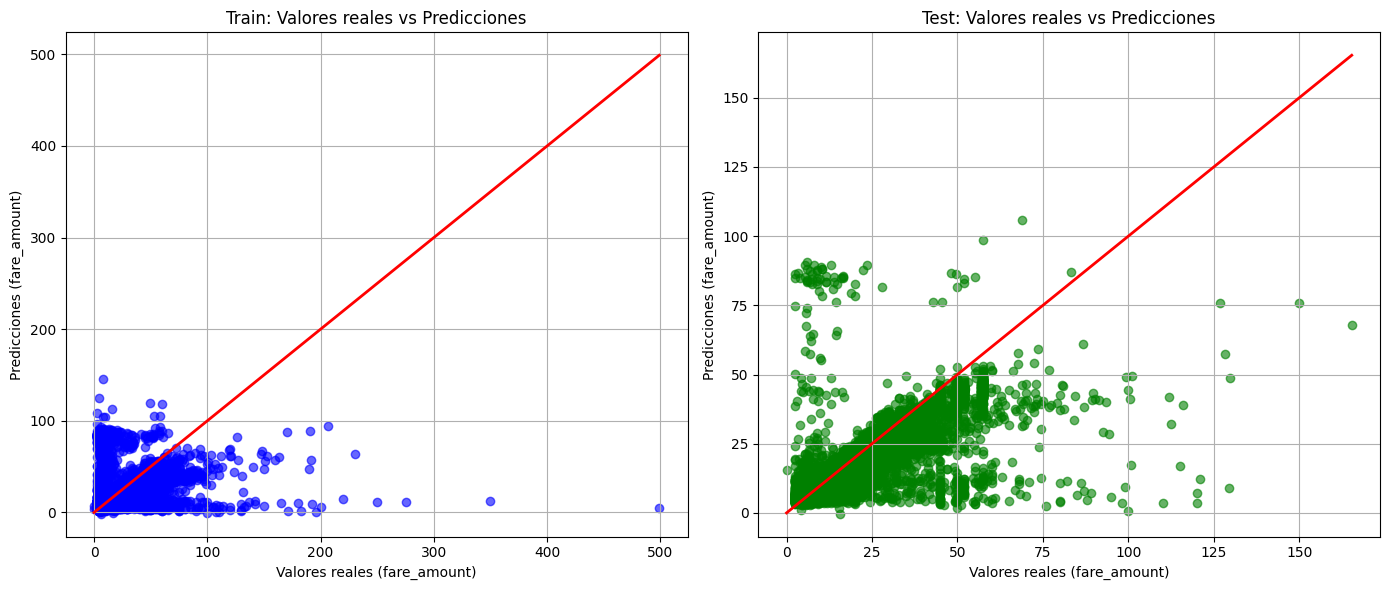

In [56]:
# Gráfica de predicciones vs valores reales para el conjunto de train y test
plt.figure(figsize=(14, 6))

# Gráfico para el conjunto de train
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Train: Valores reales vs Predicciones')
plt.xlabel('Valores reales (fare_amount)')
plt.ylabel('Predicciones (fare_amount)')
plt.grid(True)

# Gráfico para el conjunto de test
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.title('Test: Valores reales vs Predicciones')
plt.xlabel('Valores reales (fare_amount)')
plt.ylabel('Predicciones (fare_amount)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Gradiente descendiente

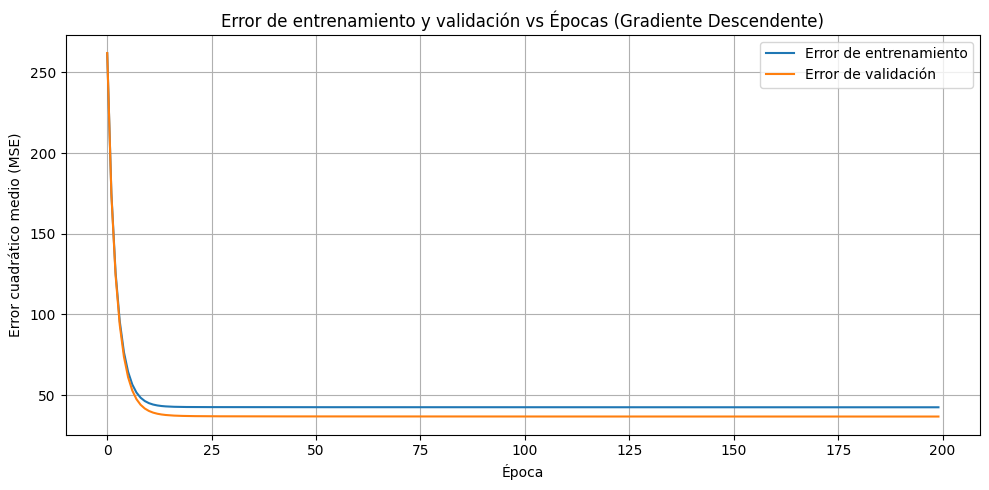

In [57]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    # Asegurar que y_train e y_val sean arrays columna
    y_train = np.array(y_train).reshape(-1, 1)
    y_val = np.array(y_val).reshape(-1, 1)

    n, m = X_train.shape
    o = X_val.shape[0]

    # Agregar columna de unos para el término independiente (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Inicializar pesos aleatoriamente
    W = np.random.randn(m + 1, 1)

    train_errors = []
    val_errors = []

    for epoch in range(epochs):
        # Predicción y error en entrenamiento
        prediction_train = X_train @ W
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Predicción y error en validación
        prediction_val = X_val @ W
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)

        # Calcular gradiente y actualizar pesos
        gradient = (-2 / n) * (X_train.T @ error_train)
        W = W - lr * gradient

    # Graficar errores
    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio (MSE)')
    plt.title('Error de entrenamiento y validación vs Épocas (Gradiente Descendente)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return W, train_errors, val_errors

# Llamada a la función
W, train_errors, val_errors = gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.1, epochs=200)


### Métodos de regularización

In [58]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [61]:
# funcion para imprimir metricas
def print_metrics(y_true, y_pred, model_name='Modelo', dataset_type='Train'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n {model_name} - {dataset_type}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²  : {r2:.4f}")


### Lasso

In [62]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_train_lasso = lasso.predict(X_train_scaled)
y_test_lasso = lasso.predict(X_test_scaled)

print_metrics(y_train, y_train_lasso, model_name='Lasso', dataset_type='Train')
print_metrics(y_test, y_test_lasso, model_name='Lasso', dataset_type='Test')



 Lasso - Train
MSE : 42.58
RMSE: 6.53
MAE : 2.84
MAPE: 29.92%
R²  : 0.5669

 Lasso - Test
MSE : 36.93
RMSE: 6.08
MAE : 2.83
MAPE: 32.70%
R²  : 0.6175


### Ridge

In [63]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_train_ridge = ridge.predict(X_train_scaled)
y_test_ridge = ridge.predict(X_test_scaled)

print_metrics(y_train, y_train_ridge, model_name='Ridge', dataset_type='Train')
print_metrics(y_test, y_test_ridge, model_name='Ridge', dataset_type='Test')



 Ridge - Train
MSE : 42.45
RMSE: 6.52
MAE : 2.81
MAPE: 29.64%
R²  : 0.5682

 Ridge - Test
MSE : 36.70
RMSE: 6.06
MAE : 2.81
MAPE: 32.22%
R²  : 0.6199


### Elastic Net

In [64]:

elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)  # l1_ratio=0.5 → mezcla 50% L1 y 50% L2
elastic.fit(X_train_scaled, y_train)
y_train_elastic = elastic.predict(X_train_scaled)
y_test_elastic = elastic.predict(X_test_scaled)

print_metrics(y_train, y_train_elastic, model_name='Elastic Net', dataset_type='Train')
print_metrics(y_test, y_test_elastic, model_name='Elastic Net', dataset_type='Test')


 Elastic Net - Train
MSE : 42.67
RMSE: 6.53
MAE : 2.92
MAPE: 30.98%
R²  : 0.5659

 Elastic Net - Test
MSE : 37.26
RMSE: 6.10
MAE : 2.91
MAPE: 33.67%
R²  : 0.6141


Por qué evaluar en Train y Test?
- (Train): Nos dice qué tan bien el modelo aprendió los datos con los que se entrenó. Si el error aquí es bajo, el modelo puede estar bien ajustado o sobreajustado (overfitting).

- (Test): Nos muestra qué tan bien generaliza el modelo a datos nuevos. Aquí se ve si el modelo realmente sirve para predecir o si solo memorizó los datos del entrenamiento.

- Si el error en Train es muy bajo pero alto en Test, probablemente el modelo sufre de overfitting. Si ambos errores son altos, es underfitting. Lo ideal es que ambos estén bajos y similares.

# Optimización de hiperparámetros

Gradiente descendiente — Variación de tasa de aprendizaje (lr) y número de épocas. Probamos distintas combinaciones de lr y epochs para observar estabilidad y convergencia del error:


 Gradiente Descendiente - lr: 0.001, epochs: 50


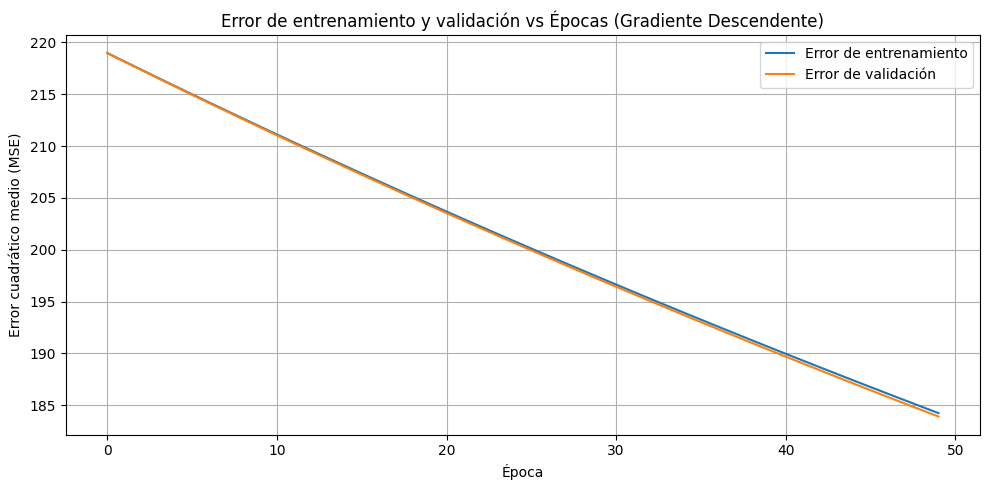


 Gradiente Descendiente - lr: 0.001, epochs: 100


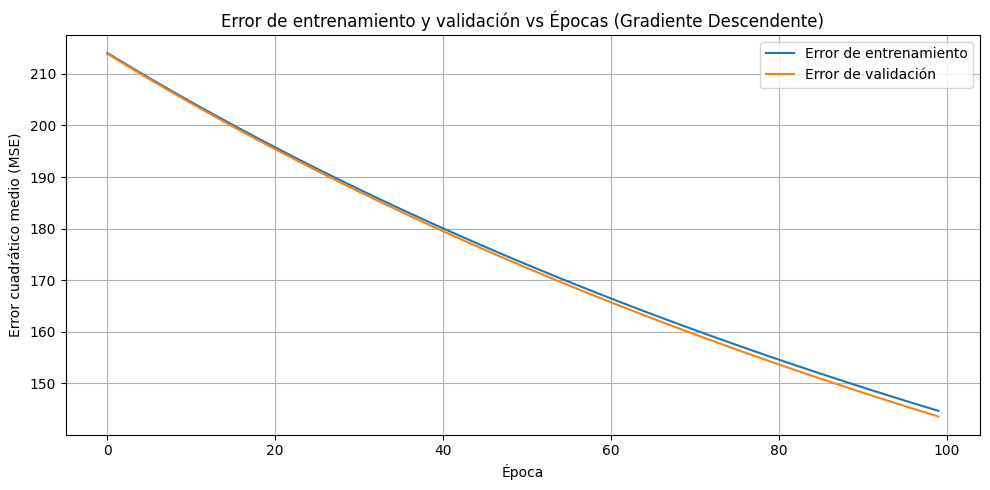


 Gradiente Descendiente - lr: 0.001, epochs: 200


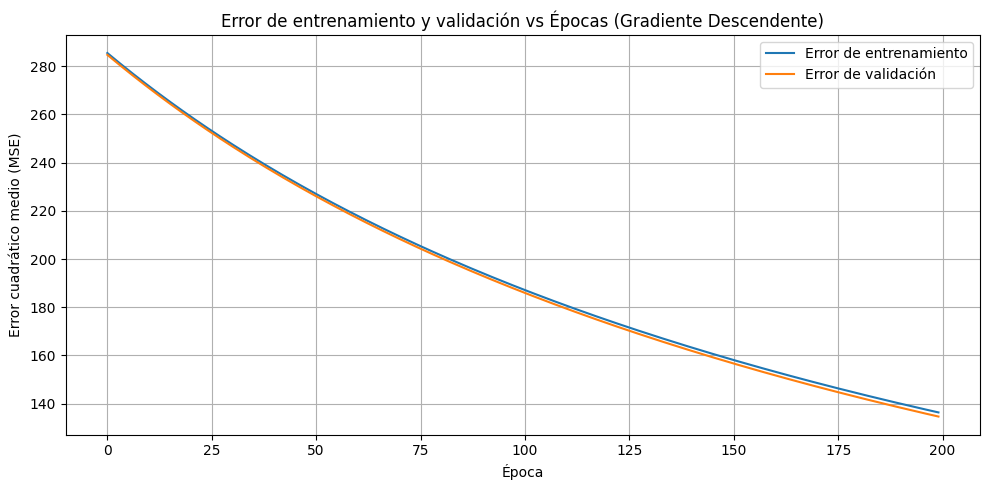


 Gradiente Descendiente - lr: 0.01, epochs: 50


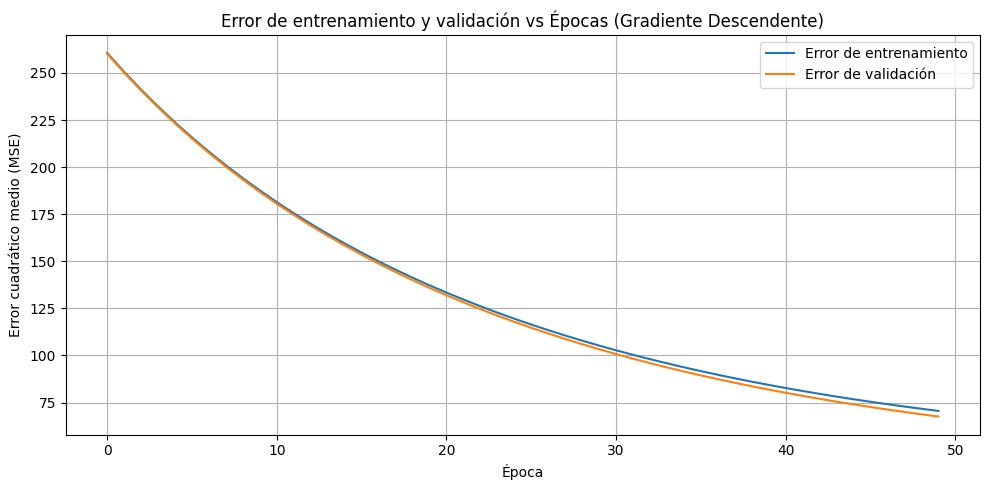


 Gradiente Descendiente - lr: 0.01, epochs: 100


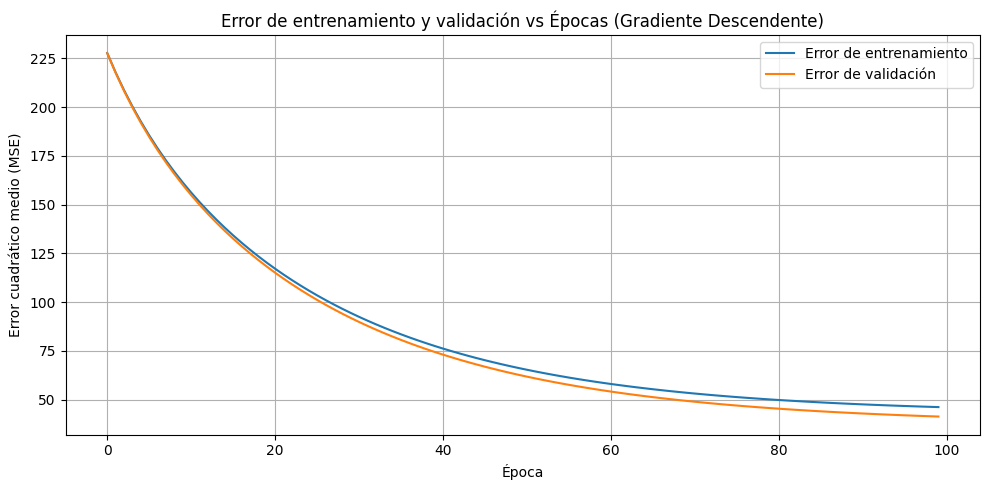


 Gradiente Descendiente - lr: 0.01, epochs: 200


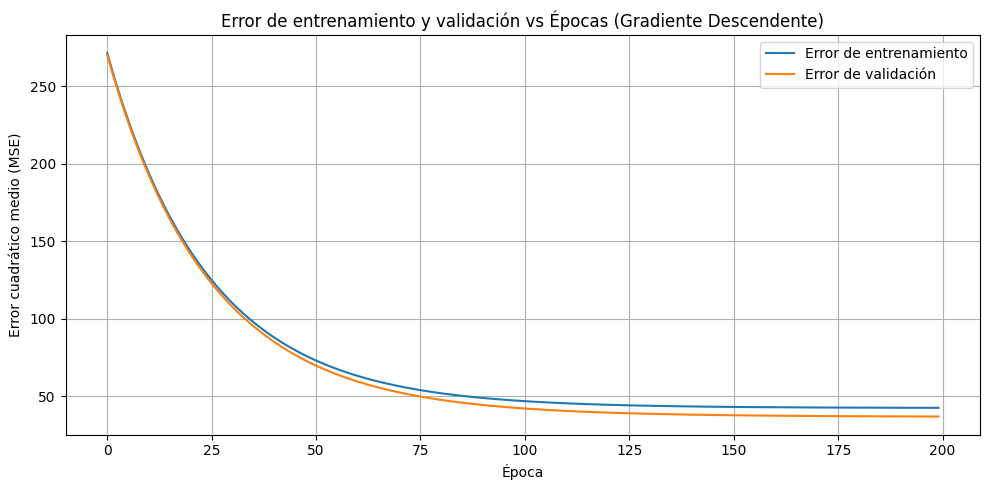


 Gradiente Descendiente - lr: 0.1, epochs: 50


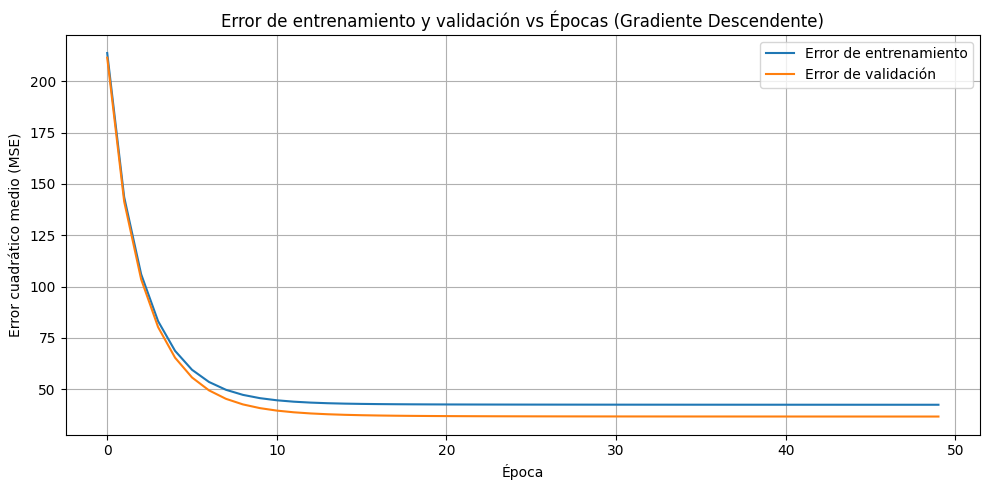


 Gradiente Descendiente - lr: 0.1, epochs: 100


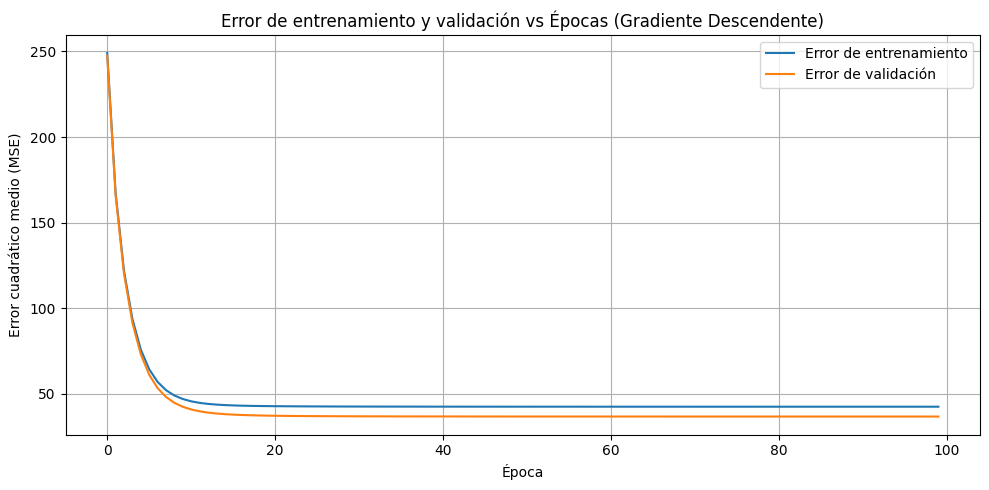


 Gradiente Descendiente - lr: 0.1, epochs: 200


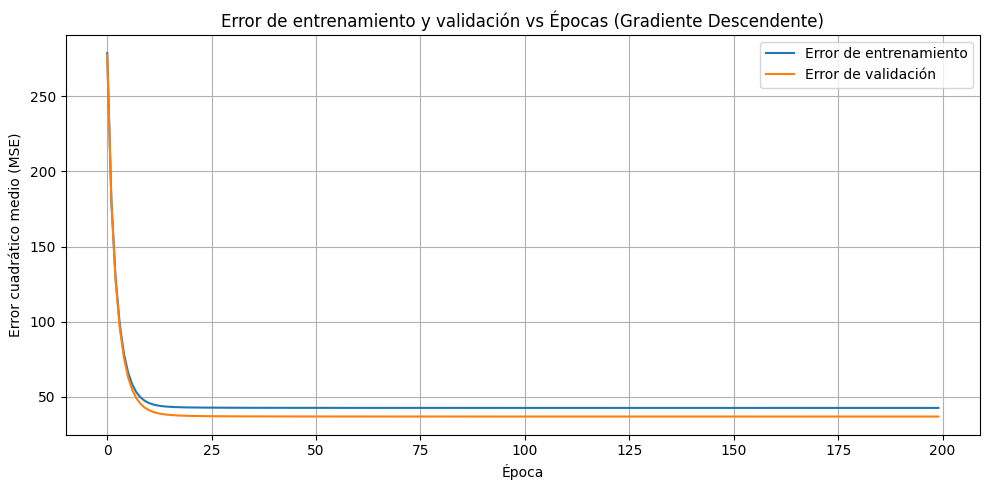

In [67]:
learning_rates = [0.001, 0.01, 0.1]
epochs_list = [50, 100, 200]

for lr in learning_rates:
    for epochs in epochs_list:
        print(f"\n Gradiente Descendiente - lr: {lr}, epochs: {epochs}")
        gradient_descent(X_train_scaled.copy(), y_train.copy(), X_test_scaled.copy(), y_test.copy(), lr=lr, epochs=epochs)


### Lasso y Ridge — Selección del hiperparámetro alpha

In [68]:
alphas = [0.001, 0.01, 0.1, 1, 10]

print("\n Ridge Regression:")
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    print(f"alpha={alpha:>5} → R² Test: {r2:.4f}")

print("\n Lasso Regression:")
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    print(f"alpha={alpha:>5} → R² Test: {r2:.4f}")



 Ridge Regression:
alpha=0.001 → R² Test: 0.6199
alpha= 0.01 → R² Test: 0.6199
alpha=  0.1 → R² Test: 0.6199
alpha=    1 → R² Test: 0.6199
alpha=   10 → R² Test: 0.6199

 Lasso Regression:


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+04, tolerance: 1.573e+03
  model = cd_fast.enet_coordinate_descent(


alpha=0.001 → R² Test: 0.6199
alpha= 0.01 → R² Test: 0.6198
alpha=  0.1 → R² Test: 0.6175
alpha=    1 → R² Test: 0.5795
alpha=   10 → R² Test: -0.0000


## Comparación de modelos
- Creamos una tabla resumen con una métrica común: el RMSE del conjunto de prueba, que representa error promedio de predicción.

In [74]:
from tabulate import tabulate
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

model_scores = []

# Regresión Lineal
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
mse_lr = mean_squared_error(y_test, lr.predict(X_test_scaled))
model_scores.append(['Linear Regression', mse_lr])

# Lasso
best_lasso = Lasso(alpha=0.1)
best_lasso.fit(X_train_scaled, y_train)
mse_lasso = mean_squared_error(y_test, best_lasso.predict(X_test_scaled))
model_scores.append(['Lasso (α=0.1)', mse_lasso])

# Ridge
best_ridge = Ridge(alpha=1.0)
best_ridge.fit(X_train_scaled, y_train)
mse_ridge = mean_squared_error(y_test, best_ridge.predict(X_test_scaled))
model_scores.append(['Ridge (α=1.0)', mse_ridge])

# Elastic Net
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)
mse_elastic = mean_squared_error(y_test, elastic.predict(X_test_scaled))
model_scores.append(['Elastic Net (α=0.1)', mse_elastic])

# Mostrar comparación
print(tabulate(model_scores, headers=['Modelo', 'MSE Test'], floatfmt=".4f"))


Modelo                 MSE Test
-------------------  ----------
Linear Regression       36.6970
Lasso (α=0.1)           36.9337
Ridge (α=1.0)           36.6970
Elastic Net (α=0.1)     37.2647


###  Conclusión sobre la comparación de modelos

Al comparar los modelos de regresión en base al **Error Cuadrático Medio (MSE)** sobre el conjunto de prueba, se observa que:

- **Regresión Lineal** y **Ridge (α=1.0)** obtienen exactamente el mismo MSE (**36.6970**), lo que indica que, en este caso, la regularización L2 no tuvo un impacto significativo sobre el ajuste.
- **Lasso (α=0.1)** muestra un MSE levemente superior (**36.9337**), lo que sugiere que al introducir la regularización L1, algunos coeficientes podrían haber sido penalizados innecesariamente, afectando mínimamente el rendimiento.
- **Elastic Net (α=0.1, l1_ratio=0.5)** es el modelo con el mayor MSE (**37.2647**), lo cual indica que la combinación de penalizaciones L1 y L2 no aportó mejoras para este conjunto de datos específico.

En resumen, **la Regresión Lineal y Ridge fueron los modelos más eficaces** para este caso particular. Esto sugiere que los datos no presentan un problema significativo de sobreajuste o multicolinealidad que pueda ser mitigado con regularización. Sin embargo, conviene destacar que estos resultados pueden cambiar con un ajuste más fino de hiperparámetros o con otras divisiones de los datos.


#  Conclusión General

En este trabajo práctico se exploraron diversos enfoques para el problema de regresión, comenzando con un modelo de **regresión lineal** base y luego avanzando a técnicas más complejas como el **gradiente descendente** y **modelos con regularización** (Lasso, Ridge, Elastic Net).

### Resumen de los pasos seguidos:

1. **Preprocesamiento y validación**: Se dividieron los datos en conjuntos de entrenamiento y prueba, evitando filtraciones de datos.
2. **Evaluación de modelos**: Se entrenaron y evaluaron varios modelos utilizando métricas como **MSE**, **RMSE** y **R²**.
3. **Regularización**: Se aplicaron técnicas como Lasso, Ridge y Elastic Net para controlar el sobreajuste, pero los resultados no mostraron mejoras significativas en comparación con la regresión lineal.
4. **Optimización de hiperparámetros**: Se ajustaron parámetros como `alpha` en los modelos de regularización y `lr` en el gradiente descendente, observando su impacto en el rendimiento.

### Resultados clave:

- Los modelos de **regresión lineal** y **Ridge** fueron los más efectivos, con un **MSE de 36.6970** en el conjunto de prueba.
- Las técnicas de regularización, aunque útiles en problemas más complejos, no ofrecieron ventajas notables en este caso.

Como conclusion, los enfoques simples como la regresión lineal funcionaron tan bien como los modelos más complejos, destacando la importancia de elegir el modelo adecuado según las características del conjunto de datos.